In [1]:
import time 

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pinocchio as pin
from scipy.optimize import least_squares
from scipy.special import huber
from projectyl.utils.properties import ELBOW, SHOULDER, WRIST
from projectyl.utils.arm import plot_optimization_curves

from projectyl.dynamics.inverse_kinematics import build_arm_model
from projectyl.utils.arm import interactive_replay_sequence
from projectyl.utils.io import Dump
from interactive_pipe.helper import _private
from typing import List, Tuple, Dict, Any
_private.registered_controls_names = [] # this is for notebooks where you re-execute cells everytime.

%load_ext autoreload
%autoreload 2
global_params = {}
build_arm_model(global_params, headless=False)
arm_robot = global_params["arm"]
viz = global_params["viz"]  

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [2]:
arm_robot.model.createData()
viz.display(arm_robot.q0)

TESTS arm moving, random constant acceleration

In [68]:
from projectyl.dynamics.simulation import build_simulation
DT = 1e-2
OS_FACTOR = 100
T = 30
out = build_simulation(arm_robot, T=T*OS_FACTOR, DT=DT/OS_FACTOR)
# rec_ground_truth_q, rec_ground_truth_vq, rec_ground_truth_aq, rec_ground_truth_tauq, rec_ground_truth_shoulder_p, rec_ground_truth_elbow_p, rec_ground_truth_wrist_p = out

In [69]:
def decimate(inp, OS_FACTOR=OS_FACTOR):
    return inp[OS_FACTOR//2::OS_FACTOR]

new_out = list(map(decimate, out))
rec_ground_truth_q, rec_ground_truth_vq, rec_ground_truth_aq, rec_ground_truth_tauq, rec_ground_truth_shoulder_p, rec_ground_truth_elbow_p, rec_ground_truth_wrist_p = new_out
len(rec_ground_truth_q)


30

In [70]:
# We will feed the optimiser with the following parameters
# ground_truth_p = [p_shoulder_1, p_elbow_1, p_wrist_1, ..., p_shoulder_T, p_elbow_T, p_wrist_T], T and nq
# The optimisation variable is
# [q_1, q_2, ..., q_T, tauq_3, tauq_4, ..., tauq_T-2]

ground_truth_p = np.concatenate([
    np.concatenate([
        rec_ground_truth_shoulder_p[i], rec_ground_truth_elbow_p[i], rec_ground_truth_wrist_p[i]]
    ) for i in range(T)]
)

# Simple case here : we feed the "exact" solution to the optimiser
initial_optim_var = np.concatenate(rec_ground_truth_q + rec_ground_truth_tauq[2:-2])


In [71]:
from projectyl.dynamics.dynamics import process_var
shoulder_frame_id = arm_robot.model.getFrameId(SHOULDER)
elbow_frame_id = arm_robot.model.getFrameId(ELBOW)
wrist_frame_id = arm_robot.model.getFrameId(WRIST)


In [72]:
from projectyl.dynamics.dynamics import get_velocity_acceleration
# get_velocity_acceleration(rec_ground_truth_q, T, nv, DT)


# Utility functions

In [73]:
def process_var(var, T, nq) -> Tuple[np.ndarray, np.ndarray]:
    # [q_1, q_2, ..., q_T, tauq_3, tauq_4, ..., tauq_T-2]

    # [ q1 , q2    q3  ,                       , qT-1, qT]
    # [ -    - , tauq_3, tauq_4, ..., tauq_T-2 ,  -   -  ]
    tq_unnormalized = var[:T * nq].reshape(T, nq) # tq =[q_1, q_2, ..., q_T]
    ttauq = var[T * nq:] # ttauq = [tauq_3, tauq_4, ..., tauq_T-2]


    # Get tq
    shoulder_quaternion_unnormalized = tq_unnormalized[:, :4] # Shouler quaternion 4 premières valeurs de q
    elbow_angle = tq_unnormalized[:, 4].reshape(T, 1)

    shoulder_quaternion_norm = np.linalg.norm(
        shoulder_quaternion_unnormalized, 
        axis=1,
        keepdims=True
    )
    
    shoulder_quaternion_normalized = shoulder_quaternion_unnormalized / shoulder_quaternion_norm

    tq = np.concatenate(
        (
            shoulder_quaternion_normalized, 
            elbow_angle
        ), 
        axis=1
    )
    assert tq.shape == tq_unnormalized.shape

    return tq, ttauq

In [74]:
def get_velocity_acceleration(tq, T, nv, DT):

    tvq = np.empty((T - 2, nv))
    # nv=4

    # Pourquoi ces opérations ne sont pas vectorizés dans pinocchio ...
    for i in range(1, T - 1):
        tvq[i - 1] = pin.difference(arm_robot.model, tq[i - 1], tq[i + 1]) / (2 * DT)

    taq = (tvq[2:] - tvq[:-2]) / (2 * DT) 

    return tvq, taq

In [75]:
def get_3D_pose_velocity_acceleration(tq, T, DT):
    # [p_shoulder_1, p_elbow_1, p_wrist_1, ..., p_shoulder_T, p_elbow_T, p_wrist_T]

    tshoulder_p = np.empty((T, 3))
    telbow_p = np.empty((T, 3))
    twrist_p = np.empty((T, 3))

    for i in range(T):
        # Forward kinematics
        pin.framesForwardKinematics(arm_robot.model, arm_robot.data, tq[i])

        # Predicted 3D points
        tshoulder_p[i] = arm_robot.data.oMf[shoulder_frame_id].translation
        telbow_p[i] = arm_robot.data.oMf[elbow_frame_id].translation
        twrist_p[i] = arm_robot.data.oMf[wrist_frame_id].translation

    # Computes speed and acceleration
    tshoulder_v = (tshoulder_p[2:] - tshoulder_p[:-2]) / (2 * DT)
    telbow_v = (telbow_p[2:] - telbow_p[:-2]) / (2 * DT)
    twrist_v = (twrist_p[2:] - twrist_p[:-2]) / (2 * DT)

    tshoulder_a = (tshoulder_v[2:] - tshoulder_v[:-2]) / (2 * DT)
    telbow_a = (telbow_v[2:] - telbow_v[:-2]) / (2 * DT)
    twrist_a = (twrist_v[2:] - twrist_v[:-2]) / (2 * DT)

    data_pos3D = np.concatenate((tshoulder_p, telbow_p, twrist_p), axis=1).flatten()
    velocity = np.concatenate(
        (tshoulder_v, telbow_v, twrist_v), axis=0).flatten()
    acceleration = np.concatenate(
        (tshoulder_a, telbow_a, twrist_a), axis=0).flatten()
    return data_pos3D, velocity, acceleration

# Cost terms definitions

In [76]:
# If the Lagrange dynamics formulation cannote be totally satisfied,
# one can relax by minimizing the difference between:
# - the Lagrange dynamics torques tau_rec predicited from q, vq and aq.
# - the current predicted torques ttauq
# question: why not also going backward in time ? ici middle point

def full_body_dynamics(tq, tvq, taq, T, nv):
    
    ttau = np.empty((T - 4, nv))

    for i in range(2, T - 2):
        ttau[i - 2] = pin.rnea(arm_robot.model, arm_robot.data, tq[i], tvq[i - 1], taq[i - 2])

    return ttau.flatten()

In [77]:
# Build the cost function
def objective(var, observed_p, T, debug=False) -> np.ndarray:
    tq, ttauq = process_var(var, T, 5)
    tvq, taq = get_velocity_acceleration(tq, T, 4, DT)
    tp, tv, ta = get_3D_pose_velocity_acceleration(tq, T, DT)
    ttau = full_body_dynamics(tq, tvq, taq, T, 4)


    if debug :
        print("Diff between 3D pose :", np.linalg.norm(observed_p - tp))
        print("Smooth velocity :", np.linalg.norm(tv))
        print("Smooth acceleration :", np.linalg.norm(ta))
        print("Smooth torque :", np.linalg.norm(ttauq))
        print("Dynamics :", np.linalg.norm(ttau - ttauq))

    res = np.concatenate([
        (observed_p - tp),
        #0.1 * tv,
        #0.1 * ta,
        #0.1 * ttauq,
        1000 * (ttau - ttauq),
    ])

    return res

In [78]:
tq_gt = np.vstack(rec_ground_truth_q)[2:-2]
tvq_gt = np.vstack(rec_ground_truth_vq)[2:-2]
ttauq_gt = np.vstack(rec_ground_truth_tauq)[2:-2]

In [79]:
gt_tot = np.concatenate((tq_gt, tvq_gt, ttauq_gt), axis=1)

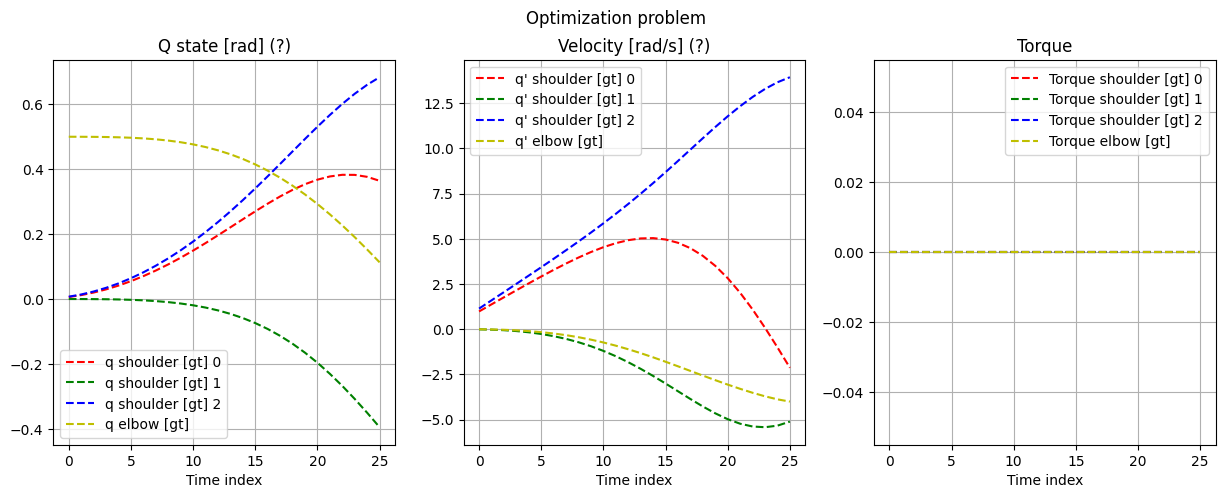

In [80]:
plot_optimization_curves([(gt_tot, "[gt]", "--"),])

# Optimization

In [81]:
initial_var = initial_optim_var.copy()
initial_var[T * arm_robot.model.nq:] = 0

In [82]:
sol = least_squares(objective, initial_var, args=(ground_truth_p, T), method="lm").x

In [83]:
np.linalg.norm(objective(sol, ground_truth_p, T, True))

Diff between 3D pose : 1.3200772859895785e-15
Smooth velocity : 13.967719436478612
Smooth acceleration : 120.7509181587779
Smooth torque : 0.24373902051248847
Dynamics : 4.438426964466758e-13


4.438426964486388e-10

In [84]:
np.linalg.norm(objective(initial_optim_var, ground_truth_p, T, True))

Diff between 3D pose : 3.7145772768024687e-16
Smooth velocity : 13.967719436478616
Smooth acceleration : 120.75091815877776
Smooth torque : 0.0
Dynamics : 0.24373902051264557


243.73902051264557

In [85]:
tq, ttauq = process_var(sol, T, 5)

In [86]:
vq, va = get_velocity_acceleration(tq, T, 4, DT)

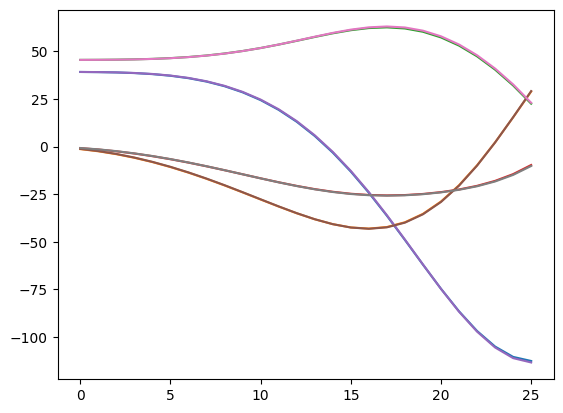

In [87]:
import matplotlib.pyplot as plt
plt.plot(va)
plt.plot(np.vstack(rec_ground_truth_aq[2:-2]))

In [88]:
estimation = np.concatenate([tq[2:-2], vq[1:-1], ttauq.reshape(T-4, 4)], axis=1)

In [89]:
#interactive_replay_sequence(
#    {
#        "estimated": res[:, :arm_robot.model.nq],
#        "groundtruth": gt_sol[:, :arm_robot.model.nq],
#    },
#    viz
#)

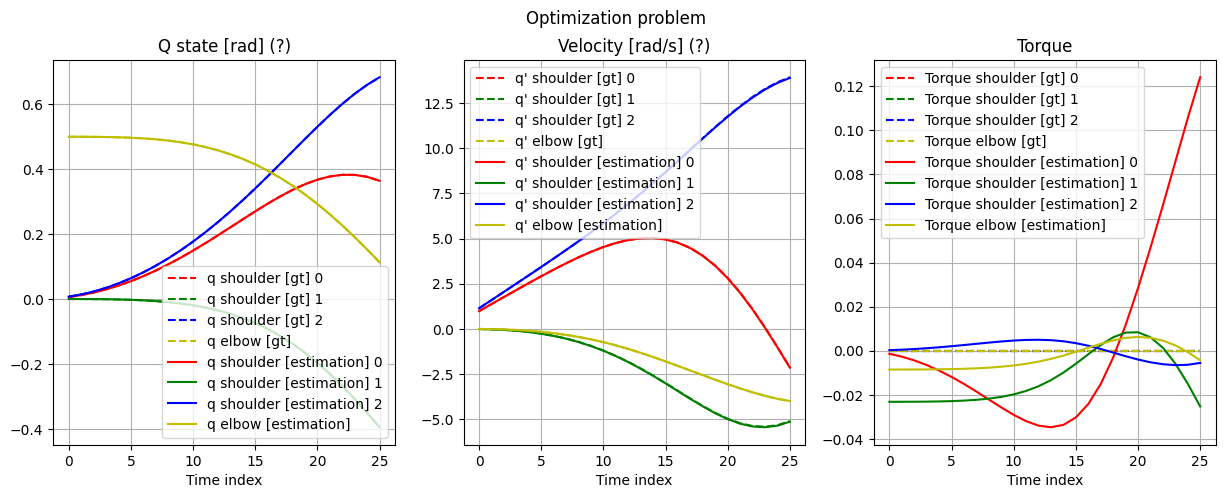

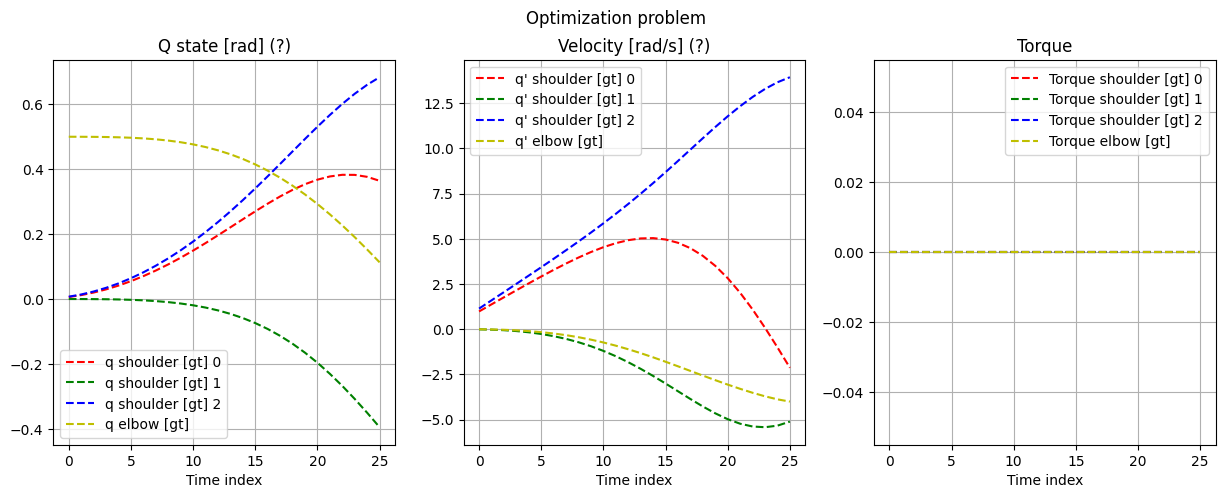

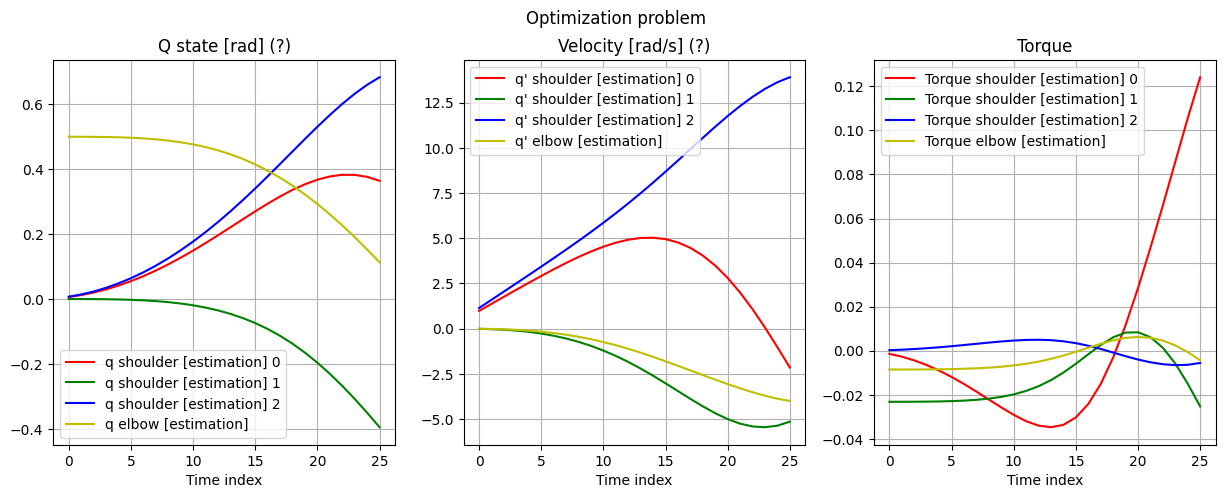

In [90]:
plot_optimization_curves([
   (gt_tot, "[gt]", "--"),
   (estimation, "[estimation]", "-"),
   ]
)
plot_optimization_curves([
   (gt_tot, "[gt]", "--"),
   ]
)

plot_optimization_curves([
   (estimation, "[estimation]", "-"),
   ]
)

In [ ]:
interactive_replay_sequence(
    {
        "estimated": estimation[:, :arm_robot.model.nq],
        "groundtruth": gt_tot[:, :arm_robot.model.nq],
    },
    viz
)

In [ ]:
tq, ttauq = process_var(sol, T, 5)

In [ ]:
for t in range(2, T - 2):

    viz.display(tq[t])

    time.sleep(1e-2)

In [ ]:
q = tq[2].copy()
vq = pin.difference(arm_robot.model, tq[1], tq[3]) / (2 * DT)

ttauq = ttauq.reshape(T - 4, 4)

for t in range(2, T - 2):
    # Compute mass and non linear effects
    M = pin.crba(arm_robot.model, arm_robot.data, q)
    b = pin.nle(arm_robot.model, arm_robot.data, q, vq)

    # Compute accelleration
    aq = np.linalg.solve(M, ttauq[t - 2] - b)

    vq += aq * DT
    q = pin.integrate(arm_robot.model, q, vq * DT)
    
    viz.display(q)
    time.sleep(1e-2)

In [ ]:
tq_gt = np.vstack(rec_ground_truth_q)
ttauq_gt = np.vstack(rec_ground_truth_tauq)[2:-2]

In [ ]:
for t in range(2, T-2):
    viz.display(tq_gt[t])
    time.sleep(1e-2)